In [1]:
import os, sys, glob
import logging
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
import astropy.units as u

from signal_generator import SignalGenerator
from background_generator import BackgroundGenerator

In [2]:
public_data_directory = "../gxn/gXn_simulations/icecube_10year_ps/"

aeffs = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_effectiveArea.csv")))
smearing = sorted(glob.glob(os.path.join(public_data_directory, "irfs/IC86_II_smearing.csv")))
uptime = [os.path.join(public_data_directory, "uptime/IC86_II_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_III_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_IV_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_V_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VI_exp.csv"),
          os.path.join(public_data_directory, "uptime/IC86_VII_exp.csv")]
data = [os.path.join(public_data_directory, "events/IC86_II_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_III_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_IV_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_V_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VI_exp.csv"),
        os.path.join(public_data_directory, "events/IC86_VII_exp.csv")]

x = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=1.0)
y = BackgroundGenerator(data)


/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:83: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


In [4]:
bg_events = y.scramble()
ra, dec = bg_events['ra'], bg_events['dec']
ra[ra > np.pi] -= 2*np.pi

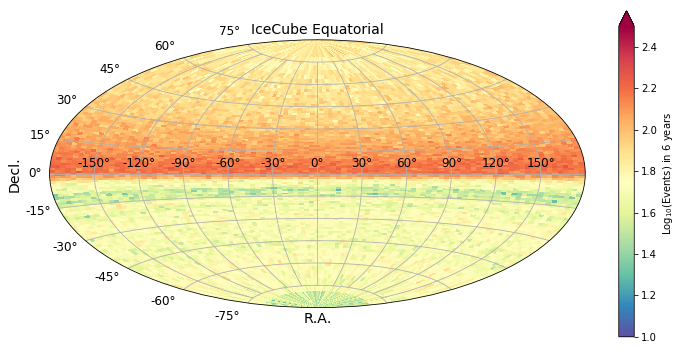

In [5]:
# Raw IceCube coordinate plot
color_map = plt.cm.Spectral_r
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='aitoff')

h, xedges, yedges = np.histogram2d(ra, dec, 
                       bins=(np.linspace(-np.pi, np.pi, 100),
                             np.arcsin(np.linspace(-1, 1, 100))))
image = plt.pcolormesh(xedges, yedges, np.log10(h).T,
                   cmap=color_map,
                   vmin=1, vmax=2.5,
                  )

ax.set_title("IceCube Equatorial", fontsize=14)
plt.xlabel('R.A.', fontsize=14)
plt.ylabel('Decl.', fontsize=14)
plt.tick_params(labelsize=12)
plt.grid(True)
plt.colorbar(image, spacing='uniform', extend='max', label=r'Log$_{10}$(Events) in 6 years')
plt.show()

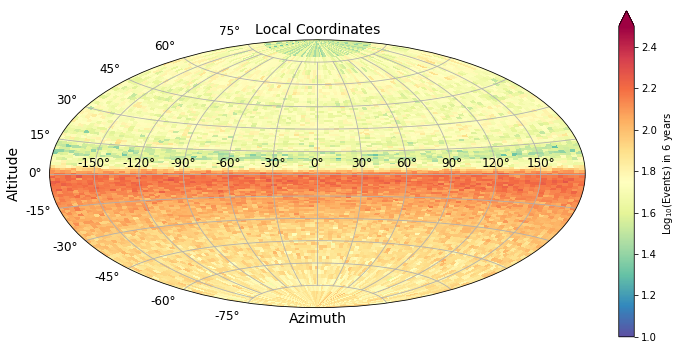

In [8]:
# Raw IceCube coordinate plot
color_map = plt.cm.Spectral_r
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='aitoff')

h, xedges, yedges = np.histogram2d(ra, -dec, 
                       bins=(np.linspace(-np.pi, np.pi, 100),
                             np.arcsin(np.linspace(-1, 1, 100))))
image = plt.pcolormesh(xedges, yedges, np.log10(h).T,
                   cmap=color_map,
                   vmin=1, vmax=2.5,
                  )

ax.set_title("Local Coordinates", fontsize=14)
plt.xlabel(r'Azimuth', fontsize=14)
plt.ylabel(r'Altitude', fontsize=14)
plt.tick_params(labelsize=12)
plt.grid(True)
plt.colorbar(image, spacing='uniform', extend='max', label=r'Log$_{10}$(Events) in 6 years')
plt.show()

In [79]:
# Rotate to KM3NeT position
km3net = EarthLocation(lat=42.8*u.deg, lon=-6.03*u.deg, height=0*u.m)

# Equatorial coordinates before averaging over a year
#time = Time('1991-06-06 12:00:00')
#km3net_local = SkyCoord(az=ra, alt=-dec, unit='rad', obstime = time, 
#                        frame='altaz', location = km3net)
#km3net_local_ra, km3net_local_dec = (km3net_local.icrs.ra.wrap_at(180*u.degree), 
#                                     km3net_local.icrs.dec)

# And after averaging over a year
annual_time = Time('1991-06-06 12:00:00') + np.random.uniform(0, 1, size=len(ra))*u.year
km3net_annual = SkyCoord(az=ra, alt=-dec, unit='rad', 
                        obstime = annual_time, 
                        frame='altaz', location = km3net)
km3net_ra, km3net_dec = (km3net_annual.icrs.ra.wrap_at(180*u.degree), 
                         km3net_annual.icrs.dec)

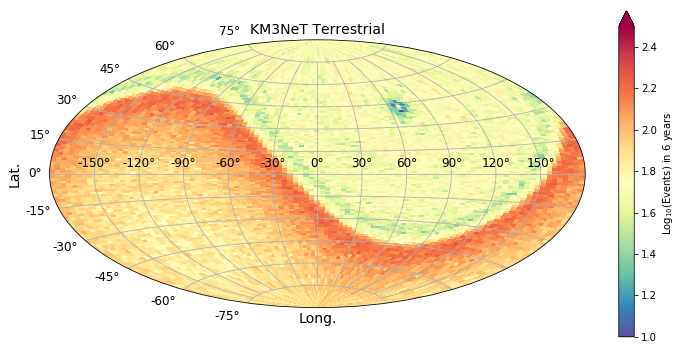

In [106]:
# Local KM3NeT coordinate plot
color_map = plt.cm.Spectral_r
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='aitoff')

h, xedges, yedges = np.histogram2d(np.array(km3net_local_ra.to(u.rad)), 
                                   np.array(km3net_local_dec.to(u.rad)), 
                                   bins=(np.linspace(-np.pi, np.pi, 100),
                                         np.arcsin(np.linspace(-1, 1, 100))))
image = plt.pcolormesh(xedges, yedges, np.log10(h).T,
                   cmap=color_map,
                   vmin=1, vmax=2.5,
                  )

ax.set_title("KM3NeT Terrestrial", fontsize=14)
plt.xlabel('Long.', fontsize=14)
plt.ylabel('Lat.', fontsize=14)
plt.tick_params(labelsize=12)
plt.grid(True)
plt.colorbar(image, spacing='uniform', extend='max', label=r'Log$_{10}$(Events) in 6 years')
plt.show()

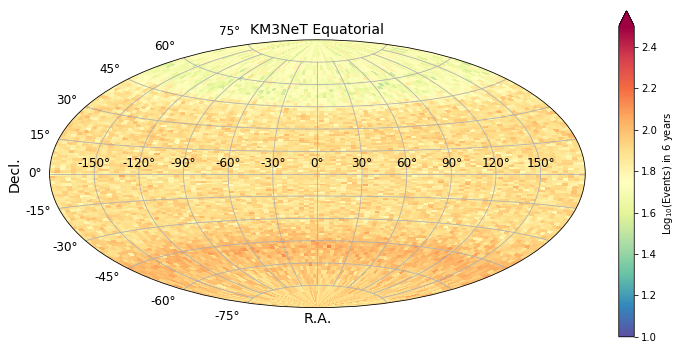

In [101]:
# Averaged KM3NeT equatorial coordinate plot
color_map = plt.cm.Spectral_r
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='aitoff')
#icrs = event_coords.icrs
#km3net_ra, km3net_dec = icrs.ra.wrap_at(180*u.degree), icrs.dec

h, xedges, yedges = np.histogram2d(np.array(km3net_ra.to(u.rad)), 
                                   np.array(km3net_dec.to(u.rad)), 
                                   bins=(np.linspace(-np.pi, np.pi, 100),
                                         np.arcsin(np.linspace(-1, 1, 100))))
image = plt.pcolormesh(xedges, yedges, np.log10(h).T,
                   cmap=color_map,
                   vmin=1, vmax=2.5,
                  )

ax.set_title("KM3NeT Equatorial", fontsize=14)
plt.xlabel('R.A.', fontsize=14)
plt.ylabel('Decl.', fontsize=14)
plt.tick_params(labelsize=12)
plt.grid(True)
plt.colorbar(image, spacing='uniform', extend='max', label=r'Log$_{10}$(Events) in 6 years')
plt.show()

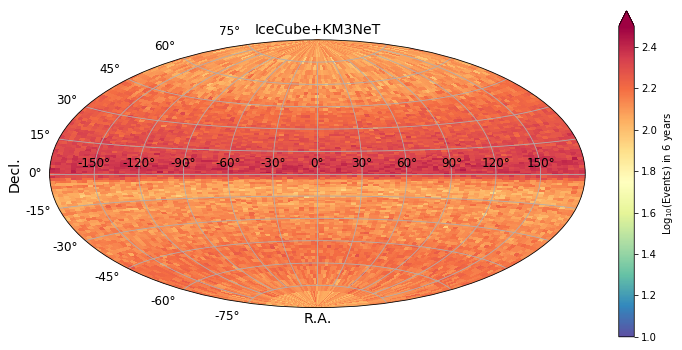

In [102]:
# Averaged KM3NeT equatorial coordinate plot
color_map = plt.cm.Spectral_r
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='aitoff')
#icrs = event_coords.icrs
#km3net_ra, km3net_dec = icrs.ra.wrap_at(180*u.degree), icrs.dec

merged_ra = np.concatenate([ra, np.array(km3net_ra.to(u.rad))])
merged_dec = np.concatenate([dec, -1*np.array(km3net_dec.to(u.rad))])

h, xedges, yedges = np.histogram2d(merged_ra,
                                   merged_dec,
                                   bins=(np.linspace(-np.pi, np.pi, 100),
                                         np.arcsin(np.linspace(-1, 1, 100))))
image = plt.pcolormesh(xedges, yedges, np.log10(h).T,
                   cmap=color_map,
                   vmin=1, vmax=2.5,
                  )

ax.set_title("IceCube+KM3NeT", fontsize=14)
plt.xlabel('R.A.', fontsize=14)
plt.ylabel('Decl.', fontsize=14)
plt.tick_params(labelsize=12)
plt.grid(True)
plt.colorbar(image, spacing='uniform', extend='max', label=r'Log$_{10}$(Events) in 6 years')
plt.show()

In [18]:
x = SignalGenerator(aeffs, smearing, uptime,
                    angular_resolution_scale=1.0)

/data/condor_builds/users/mlarson/public_data_trials/signal_generator.py:77: RuntimeWarning: divide by zero encountered in log
  - np.cos(np.radians(smearing['AngErr_max[deg]'])))))


template nside: 128
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


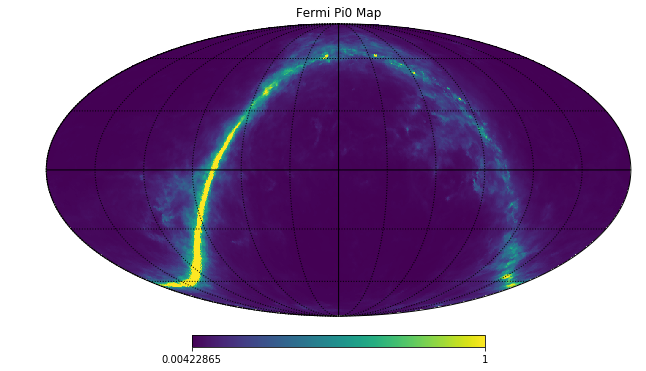

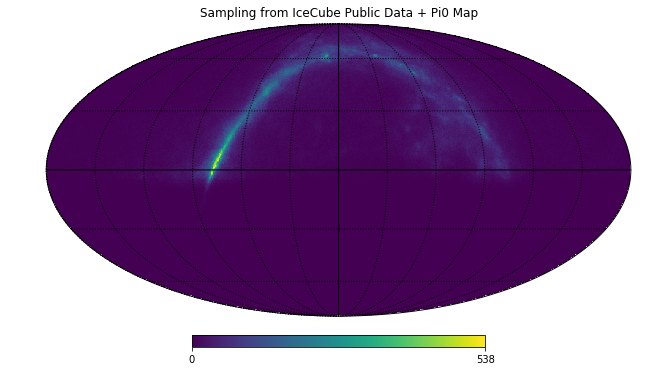

In [19]:
def pi0_powerlaw_integral_flux(map_value, emin, emax, 
                               normalization=4.43e-19, E0=1e5, index=-2.7):
    if index > 0:
        logging.error("Please give a spectral index below 0")
        sys.exit(1)

    integral = map_value * normalization/E0**index
    if index == -1:  integral *= np.log(emax/emin)
    elif index != -1:
        integral *= (emax**(1+index) - emin**(1+index))/(1+index)
    return integral

# Load a healpix map for testing
pi0_template = np.load("./template.npy")
print('template nside:', hp.npix2nside(len(pi0_template)))
hp.mollview(pi0_template, max=1, flip='geo', title='Fermi Pi0 Map')
hp.graticule(coord='E',)

# Generate events from it and plot them
events = x.generate_from_healpix(pi0_template, pi0_powerlaw_integral_flux)
event_map = bin_to_healpix(128, np.degrees(events['ra']), np.degrees(events['dec']))
hp.mollview(event_map, flip='geo', title='Sampling from IceCube Public Data + Pi0 Map')
hp.graticule(coord='E',)
